In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [114]:
"""
N: # input_dim
M : # of sequence
K : # of tasks
T : # of a single task step
"""
N = 500
M = 2
K = 3
T=4


def gram_schmidt(N, K):
    """
    Given the dimension space dimension N, generate K random vectors and its orthogonal spans
    """
    
    def proj(u,v):
        """
        Return projection of v to u
        """
        return np.dot(v,u)/np.dot(u,u) * u
    
    V=np.random.normal(loc = 0., scale = 1, size = (K, N))
    U=np.zeros_like(V)
    
    ## Initialise u1 to v1
    U[0] = V[0]
    
    ## Gram-schomidt process
    for k in range(1,K):
        projection_terms = [proj(U[i], V[k]) for i in range(k)]
        U[k] = V[k] - np.sum(projection_terms, axis=0)
    
    return V, U

In [146]:
class Simulator():
    def __init__(self, WT, WS, VT, VS, lr_w, lr_wc, lr_vc):
        self.WT = WT
        self.WS = WS
        self.VT = VT
        self.VS = VS
        self.lr_w = lr_w
        self.lr_wc = lr_wc
        self.lr_vc = lr_vc
        self.input_dim, self.num_task, self.num_chunk, self.num_steps = self.WT.shape

    def setup_train(self):
        if self.WT is None:
            self.WT = np.random.normal(loc=0.0,
                                       scale=1.0,
                                       size=(self.num_task, self.input_dim))
        if self.WS is None:
            self.WS = np.random.normal(loc=0.0,
                                       scale=1.0,
                                       size=(self.num_task, self.input_dim))
        if self.VT is None:
            self.VT = np.random.normal(loc=0.0, scale=1.0, size=(self.num_task))
        if self.VS is None:
            self.VS = np.random.normal(loc=0.0, scale=1.0, size=(self.num_task))

    def setup_history(self, num_update):
        self.history = {
            'P': np.zeros((num_update, self.num_task)),
            'Q': np.zeros((num_update, self.num_task)),
            'R': np.zeros((num_update, self.num_task)),
            'VS': np.zeros((num_update, self.num_task, self.num_chunk)),
            'P_tilde': np.zeros((num_update)),
            'VSVT': np.zeros((num_update))
        }

    def update_history(self, history_index):
        
        a=[]
        Q = self.WS[:,:,0,0].T@self.WS[:,:,0,0] / self.input_dim
        R = self.WS[:,:,0,0].T @ self.WT[:,:,0,0] / self.input_dim
        P = 1 - np.arccos(np.diagonal(R) / np.sqrt(np.diagonal(Q))) / np.pi
        for i in range(100):
            x = np.random.normal(loc=0.0,
                             scale=1.0,
                             size=(self.input_dim, self.num_task, self.num_chunk,
                                   self.num_steps))
            (y, y_sign, y_hat,
             y_hat_sign), (y_tilde, y_tilde_hat, y_tilde_sign,
                           y_tilde_hat_sign) = self.inference2(x)
            
            a.append(y_tilde_sign == y_tilde_hat_sign)
            
        self.history['P_tilde'][history_index] = np.mean(a)
        self.history['VSVT'][history_index] = np.dot(self.VS.flatten() ,self.VT.flatten())/np.linalg.norm(self.VS) / np.linalg.norm(self.VT)
        self.history['P'][history_index] = P   
        self.history['Q'][history_index] = np.diag(Q)
        self.history['R'][history_index] = np.diag(R)
        self.history['VS'][history_index] = self.VS[:,:,0]
        
    def step1(self):
        x = np.random.normal(loc=0.0,
                             scale=1.0,
                             size=(self.input_dim, self.num_task,
                                   self.num_steps))
        
        y, y_hat, y_sign, y_hat_sign = self.inference1(x)
        
        for k in range(self.num_task):
            if np.all(y_sign[k] == y_hat_sign[k]):
                dW = (1 / np.sqrt(self.input_dim) * y_sign[k] *
                      x[:,k]).mean(axis=-1)
                self.WS[:,k,:,:] += self.lr_w * np.tile(dW[:,None, None], [1,self.num_chunk,self.num_steps])
                self.WS = np.divide(self.WS * np.sqrt(self.input_dim),
                           np.linalg.norm(self.WS, axis=0)[None,:,:,:])
        
        
        
    def step2(self):

        x = np.random.normal(loc=0.0,
                             scale=1.0,
                             size=(self.input_dim, self.num_task, self.num_chunk,
                                   self.num_steps))

        (y, y_sign, y_hat,
         y_hat_sign), (y_tilde, y_tilde_hat, y_tilde_sign,
                       y_tilde_hat_sign) = self.inference2(x)
    
    
        if (y_tilde_sign == y_tilde_hat_sign).all():
            dW=1/np.sqrt(self.input_dim)*np.einsum('ijk, jkl->ij',np.einsum('ijkl,kl->ijk', x, y_tilde_hat_sign), self.VS)/self.num_chunk/self.num_steps
            dV = 1/np.sqrt(self.input_dim)*np.einsum('ijk, jk->ij', y_hat, y_tilde_hat_sign)/self.num_chunk/self.num_steps
            self.WS += self.lr_wc * np.tile(dW[:,:,None,None], [1,1,self.num_chunk, self.num_steps])
            self.VS += self.lr_vc * np.tile(dV[:,:,None], [1,1,self.num_steps])
            self.VS /= np.linalg.norm(self.VS, axis=0)
            self.WS = np.divide(self.WS * np.sqrt(self.input_dim),
                           np.linalg.norm(self.WS, axis=0)[None,:,:,:])
            
    def inference1(self,x) :
        y = np.sum(self.WT[:,:,0,:]*x, axis = 0)/np.sqrt(self.input_dim) ## num_task * num_chunk * num_step
        y_hat = np.sum(self.WS[:,:,0,:]*x, axis = 0)/np.sqrt(self.input_dim) 
        y_sign = np.sign(y)
        y_hat_sign = np.sign(y_hat)
        
        return y, y_hat, y_sign, y_hat_sign
            
    def inference2(self, x):
        
        y = np.sum(self.WT*x, axis = 0)/np.sqrt(self.input_dim) ## num_task * num_chunk * num_step
        y_hat = np.sum(self.WS*x, axis = 0)/np.sqrt(self.input_dim) 
        y_sign = np.sign(y)
        y_hat_sign = np.sign(y_hat)

        y_tilde = np.sum(self.VT*y, axis=0) ## num_chunk * num_step        
        y_tilde_hat = np.sum(self.VS*y_hat, axis=0)
        y_tilde_sign = np.sign(y_tilde)
        y_tilde_hat_sign = np.sign(y_tilde_hat)

        return (y, y_sign, y_hat, y_hat_sign), (y_tilde, y_tilde_hat,
                                                y_tilde_sign, y_tilde_hat_sign)
    
    
    def train(self, nums_iter, update_frequency):
        self.setup_history(num_update=np.sum(nums_iter) // update_frequency)
        self.setup_train()
        for i in range(nums_iter[0]):
            self.step1()
            if i % update_frequency == 0:
                self.update_history(history_index=i // update_frequency)
                
        for i in range(nums_iter[1]):
            self.step2()
            if i % update_frequency == 0:
                self.update_history(history_index=((i + nums_iter[0]) // update_frequency))
        

In [147]:
lr_w = 1
lr_wc =1
lr_vc =1
VT = np.repeat(np.array([[2.,1.,0.,], [1.,0.,1.]]).T[:,:,None],T, axis= -1) ## K*M*T
_, wt=gram_schmidt(N, K)
for w in wt:
    w /= (np.linalg.norm(w)/np.sqrt(N))
wt = wt.T


WT = np.tile(wt[:,:,None,None], [1,1,M,T]) ## N*K * M * T
WS = np.tile(np.random.normal(0, .1, (N, K))[:,:,None,None], [1,1,M,T])
VS = np.repeat(np.random.normal(0,1,(M,K)).T[:,:,None],T, axis= -1)
VS /= np.linalg.norm(VS, axis=0)
WS=np.divide(WS * np.sqrt(N), np.linalg.norm(WS, axis=0)[None,:,:,:])


VS_curri = VS.copy()
VT_curri = VT.copy()
WT_curri = WT.copy()
WS_curri = WS.copy()

In [152]:
sim_base = Simulator( WT, WS, VT, VS, lr_w, lr_wc, lr_vc)
sim_base.train(np.array([0,int(2e+5)]), 1000)

In [148]:
sim_curri = Simulator( WT_curri, WS_curri, VT_curri, VS_curri, lr_w, lr_wc, lr_vc)
sim_curri.train(np.array([int(1e+5),int(1e+5)]), 1000)

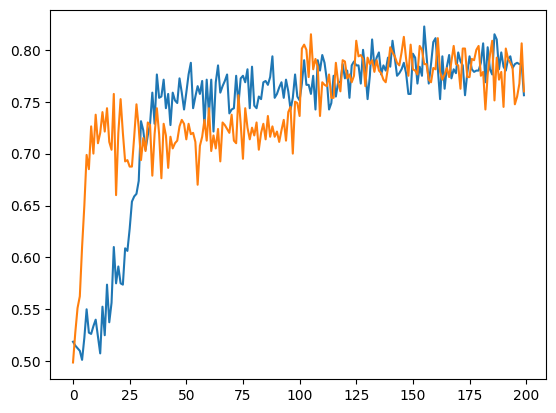

In [155]:
plt.plot(sim_base.history['P_tilde'])
plt.plot(sim_curri.history['P_tilde'])

In [136]:
x = np.random.normal(loc=0.0,
                         scale=1.0,
                         size=(N, K, M,T))

In [143]:
(y, y_sign, y_hat, y_hat_sign), (y_tilde, y_tilde_hat,
                                                y_tilde_sign, y_tilde_hat_sign) = sim_base.inference2(x)

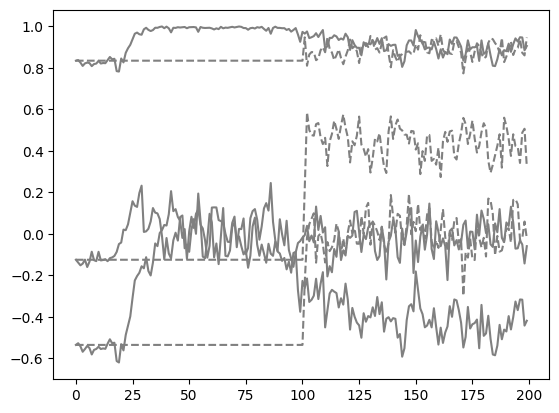

In [161]:
plt.plot(sim_base.history['VS'][:,:,0], c ='gray')
plt.plot(sim_curri.history['VS'][:,:,0], ls='--', c ='gray')

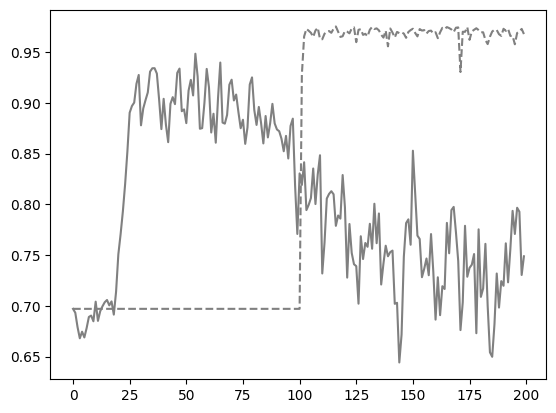

In [162]:
plt.plot(sim_base.history['VSVT'], c ='gray')
plt.plot(sim_curri.history['VSVT'], ls='--', c ='gray')